# Getting Started with RAiDER

**Author**: Jeremy Maurer, David Bekaert, Simran Sangha, Yang Lei, Brett Buzzanga - Jet Propulsion Laboratory, California Institute of Technology

This notebook provides an overview of how to get started using the RAiDER package for estimating tropospheric RADAR delays, and other functionality included in the **raider.py** program. We give an example of how to download and process delays using the ERA-5 weather model for the Los Angeles region. 

In this notebook, we will demonstrate how to:
- Use the raider.py command-line utility to download and process tropospheric delays
- Generate Zenith Delays over the Los Angeles region
- Generate Zenith Delays for a set of GNSS stations over the Los Angeles region

The notebook will take approximately 15 minutes to run all the way through aside from the data download step. 

<div class="alert alert-warning">
The initial setup (<b>Prep A</b> section) should be run at the start of the notebook. The overview sections do not need to be run in order. 
</div>

<div class="alert alert-danger">
<b>Potential Errors:</b> 
    
- Pandas 1.2.0 or greater is required for some of the the plotting examples.   
- RAiDER needs to be installed to run this notebook  
</div>


<div class="alert alert-info">
    <b>Terminology:</b>
    
- *Acquisition*: A single image acquired by a satellite at a particular time
- *AOI*: Area of interest: the lat/lon area (in RAiDER a square region) containing your query points
- *Interferogram*: An unwrapped image containing the surface displacement accumulated between two acquisitions.
- *SLC*: Single-look complex image. A complex single-band raster that contains a single focused RADAR frame from a SAR satellite. For Sentinel-1, SLCs are Level-1 products. 
- *Weather model*: A reanalysis weather product defining temperature, pressure, and humidity on a regular grid in some coordinate system (e.g., at regular lat/lon intervals in the standard EPSG:4326 reference frame).
- *Delay*: The apparent displacement in an interferogram that occurs solely due to changes in weather conditions between two acquisitions.
    </div>
    

## Table of Contents

[**Overview of the raiderDelay.py program**](#overview)  
[1. Details of the user input options](#user-input)  
[- DateList](#date_arg)  
[- Time](#time_arg)  
[- Area of Interest](#aoi_arg)  
[- Line-of-sight information](#los_arg)   
[- Height information](#height_arg)  
[- Weather Model Type](#weather_model_arg)  
[- Other Runtime Parameters](#runtime_arg)
  
[**Example Calculations**](#examples)  
[1. Downloading the weather model data using a bounding box](#bounding_box_example)  
[2. Compute Zenith Delays using a bounding box](#bounding_box_ztd)  
[3. Compute Zenith Delays using a list of GNSS stations](#station_list_example)  
[4. Visualizing Zenith Delays for a list of GNSS stations](#station_list_visualization)  
[5. Compute Slant Delays using ISCE raster files](#raster_example)  

## Prep: Initial setup of the notebook

# Set up a custom logging location
Please run the three cells below prior to running the rest of the notebook to ensure RAiDER is installed and set your working directory. You can change the relevant directories as desired for your system.  

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [2]:
# Set up a custom logging location
log_dir = './logs/'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

In [3]:
## Defining the home and data directories
tutorial_home_dir = os.path.abspath(os.getcwd())
work_dir = os.path.abspath(os.getcwd())
print("Tutorial directory: ", tutorial_home_dir)
print("Work directory: ", work_dir)

# Verifying if RAiDER is installed correctly
try:
    import RAiDER
except:
    raise Exception('RAiDER is missing from your PYTHONPATH')

os.chdir(work_dir)

Tutorial directory:  /Users/carissamaurer/Desktop/RAiDER-docs/notebooks/RAiDER_tutorial
Work directory:  /Users/carissamaurer/Desktop/RAiDER-docs/notebooks/RAiDER_tutorial


## Overview of the raider.py program
<a id='overview'></a>

**`raider.py`** is a command-line program written in Python that allows for easy downloading and processing of tropospheric weather delays for InSAR correction or comparison with GNSS tropospheric delays.
raider.yaml shows all the different options that can be passed to RAiDER; the software is extensible such that arguments can also be passed for custom workflows if desired. 

In [4]:
# Running raider.py -h will print the help menu
!raider.py -h

usage: calcDelays [-h] [-g] [--download_only] [customTemplateFile]

Command line interface for RAiDER processing with a configure file.Default options can be found by running: raider.py --generate_config

positional arguments:
  customTemplateFile    custom template with option settings. ignored if the
                        default smallbaselineApp.cfg is input.

options:
  -h, --help            show this help message and exit
  -g, --generate_template
                        generate default template (if it does not exist) and
                        exit.
  --download_only       only download a weather model.

Examples of use:
	 raider.py customTemplatefile.cfg
	 raider.py -g


### Specifying the log file location

You can specify the write location of the log files at the command line. This is done using the following format: 

`raider.py ++logger_path './logs/' [++process calcDelays] <configuration file>`

An example is shown below

## Details of the user input options
<a id='user-input'></a>
RAiDER is quite flexible in terms of the input arguments it allows.  
Options are specified in a configuration file. An example is shown below and in raider_example_1.yaml

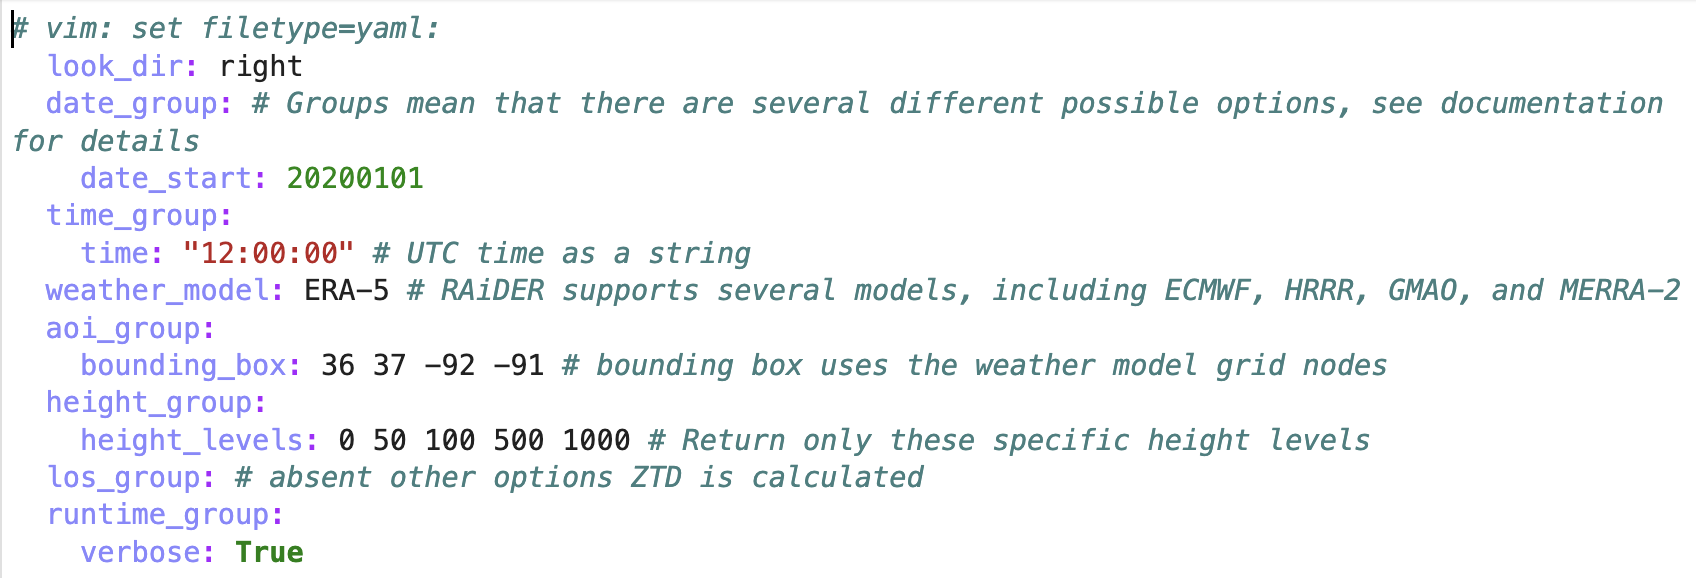

### 1. weather_model
<a id='weather_model_arg'></a>

This parameter is required. 

RAiDER supports several weather models, including: 
- ERA-5,
- ERA-5T,
- ERA-I,
- MERRA-2,
- HRRR,
- GMAO,
- HRES, and
- NCMR

Custom weather models can also be defined using the [template file](https://github.com/dbekaert/RAiDER/blob/8265cfb05678b156f10ad9866f5753fbd91b6f7f/tools/RAiDER/models/template.py) to define a custom reader and adding the model to the [ALLOWED_MODELS](https://github.com/dbekaert/RAiDER/blob/8265cfb05678b156f10ad9866f5753fbd91b6f7f/tools/RAiDER/models/allowed.py) list. 
Setting up the licensing and API keys for each weather model is different; see [WeatherModels.md](https://github.com/dbekaert/RAiDER/blob/8265cfb05678b156f10ad9866f5753fbd91b6f7f/WeatherModels.md) in the main RAiDER repository for more details. 

### 2. date_group
<a id='date_arg'></a>

This argument group is required. 

Dates are specified as either a single date, a date range, or a date list.  
`date_start`: a single date, specified in psuedo-ISO 8601 format: 20180101, 2018-01-01, etc.   
`date_end`: a single date, specified in psuedo-ISO 8601 format, last date in range minus one `date_step` to process.  
`date_step`: integer, interval in days between date_start and date_end to process.  
`date_list`: Python list of dates to process in psuedo-ISO 8601 format.  

### 3. time_group
<a id='time_arg'></a>

This argument is required. 

`time`: UTC time to process in psuedo-ISO 8601 format. Accepted formats include:
1) T020000  
2) T02:00:00.000  
3) T0200  
4) 12:00:00  
5) 120000  
etc. 

`time_end`: Last UTC time to consider when processing an orbit file. This option is only needed if an orbit file is specified in the `los_group`

### 4. aoi_group
<a id='aoi_arg'></a>

This group is required if not pulling lat/lon info from a geocoded file (see `los_group` options).

RAiDER can handle several different types of AOIs: 
1) `bounding_box`: a bounding box in SNWE format, in which case the weather model grid nodes are used for x/y or lat/lon locations.  
2) `lat_file, lon_file`: Latitude and longitude grid files in gridded radar coordinates; e.g., files generated using ISCE
3) `station_file`: a comma-delimited file containing at minimum the columns "Lat" and "Lon," and optionally "Hgt_m."  
4) `utm_zone, grid_x, grid_y`: A UTM grid with specified x- and y-spacing in meters.  
5) A geocoded DEM or line-of-sight files, from which the lat/lon information can be used (see DEM/LOS options below).  

### 5. height_group
<a id='height_arg'></a>

This group is optional. 

Ellipsoidal heights are needed to compute absolute delays.
If using a bounding box or UTM cube, the heights of the weather model grid will be used by default; optionally a list of height_levels may be passed. 
For lat/lon rasters or a station file, a DEM can either be provided by the user or downloaded on the fly. Options include: 
1) `dem`: user-provided DEM file to use
2) `use_dem_latlon`: This option should be specified as True if the user wishes to compute delays on the DEM grid. **NOTE**: This option is only available for ZTD calculation. 
3) `height_file_rdr`: A gridded height file in radar coordinates, such as produced by ISCE. This is to be used with corresponding lat/lon gridded files (see the information on [AOI group](#aoi_arg) above). 
4) `height_levels`: A Python list of height levels. Can be used with the bounding box / UTM grid AOI options and will return delays at the specified heights. 
5) If no DEM is specified and a bounding box / UTM cube is not used, RAiDER will automatically download the [Copernicus GLO-30 DEM](https://spacedata.copernicus.eu/explore-more/news-archive/-/asset_publisher/Ye8egYeRPLEs/blog/id/434960) on the fly and interpolate to the specified query points in the AOI group. 

**NOTE**: No DEM is needed for the `bounding_box` option. If nothing is specified under this group, delays will be calculated at the weather model grid nodes. 
If `height_levels` is specified, delays will be calculated at the weather model grid lat/lon coordinates and the specified heights. 
If either of these options or a UTM grid is provided, delays are returned as a 3D cube in netcdf file format. 

### 6. los_group
<a id='los_arg'></a>

This option is optional and used to specify line-of-sight information. 

Three options are available in RAiDER. Calculation of: 
1) Zenith delays (ZTD)
2) Slant delays (STD) by projection of ZTD using the incidence angle: STD = ZTD / cos(inc)
3) Slant delays (STD) by using numerically integrating the delays along along raypaths extending from the ground pixels to the top of the atmosphere. The rays follow the look vector at the ground pixel (i.e. no bending). 

ZTD is calculated by default. 

STD parameters include:  
`ray_trace`: whether or not to use ray-tracing if line-of-sight files are provided; i.e. option 3 above as opposed to projection, option 2 above.  
`zref`: if `ray_trace` is True, then this is the maximum integration height to use in meters.  

STD input options include:  
`los_file`: a gridded raster file containing look vector information. Format is specified by `los_convention`.  
`los_convention`: File format of the `los_file`. Options are `isce` or `hyp3`.  
`los_cube`: a NETCDF file containing georeferenced look vectors defined on a 3D grid.  
`orbit_file`: A compatible orbit file to use in determining look vectors.  

ISCE format line-of-sight files are two-band files with incidence angle in band 1 and heading in degrees clockwise from north in band 2. 

HYP3 format is ...

### 7. runtime_group
<a id='runtime_arg'></a>

RAiDER allows user flexibility by specifying a variety of runtime parameters, including directories to write to, file formats, and projections. 

#### raster_format
- rasterio-compatible raster image format
- Default is GTiff
- Only used when outputs are rasters

#### output_directory
- This specifies the location of the output files. 
- Default is the current directory

#### weather_model_directory
- Specifies the directory location of/to write weather model files
- Default is \<output_location\>/weather_files

#### output_projection
- CRS (geographic projection) of the output delays. 
- Default is WGS-84

In [5]:
# To see many of the options that RAiDER supports, you can generate the default config file
!raider.py -g

Wrote: /Users/carissamaurer/Desktop/RAiDER-docs/notebooks/RAiDER_tutorial/raider.yaml


## Examples using RAiDER
<a id='runtime_arg'></a>

In this section we will demostrate some of the basic capabilities of RAiDER, using a region in southern California shown below. 
The study area is around Los Angles, chosen to be a a square box 10 x 10 deg centered on 34 deg latitude, -118 deg  longitude. (See the optical image below.)

![Optical Image at Los Angeles]()
<img src="img/optical.png" width="300" height="150">

RAiDER uses weather model data from third parties to calculate weather model delays. For this excercise we will use the weather model available from the __[Global Model Assimilation Office](https://gmao.gsfc.nasa.gov/weather_prediction/)__ at NASA. 

You can also try the ERA-5 model from the __[European Medium-range Weather Forecast](https://www.ecmwf.int/)__ if you have __[access to ECMWF weather models](https://github.com/dbekaert/RAiDER/blob/dev/WeatherModels.md)__, simply change "GMAO" to "ERA5".

In [6]:
# take a look at the configuration file
with open('example_yamls/raider_example_LA_bbox-1.yaml', 'r') as f:
    for line in f.readlines():
        print(line.strip())

# vim: set filetype=yaml:
look_dir: right
date_group: # Groups mean that there are several different possible options, see documentation for details
date_start: 20200103
time_group:
time: "00:00:00" # UTC time as a string
weather_model: GMAO # RAiDER supports several models, including ECMWF, HRRR, GMAO, and MERRA-2
aoi_group:
bounding_box: 25 45 -123 -113 # bigger bounding box than raider_example_2.yaml
height_group:
height_levels: 0 50 100 500 1000 # Return only these specific height levels
los_group: # absent other options ZTD is calculated
runtime_group:
verbose: True




## Compute Zenith Delays for a bounding box
<a id='bounding_box_ztd'></a>

If you only specify a bounding box as your AOI, RAiDER will compute the Zenith delay at the locations of the native grid nodes of the weather model itself. Because our bounding box is the same as before, RAiDER will skip the download step and directly process the delays. 

RAiDER will warn you that it is using the existing weather model file, which is specific to a 1) date, 2) time, 3) model, and 4) AOI. 

In [5]:
# Try downloading the data 
!raider.py ++logger_path './logs/' example_yamls/raider_example_LA_bbox-1.yaml

Invalid extension GTiff for cube. Defaulting to .nc
Output cube spacing: 0.02 degrees
Output SNWE: [24.94, 45.06, -123.06, -112.94]
Starting to run the weather model calculation
Requested date,time: 20200103, 00:00
Beginning weather model pre-processing
Weather model HRRR is available from 2016-07-15 to Present
Weather model HRRR is available from 2016-07-15 to Present
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2020-Jan-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
/Users/carissamaurer/opt/anaconda3/envs/RAiDER/lib/python3.11/site-packages/herbie/core.py:797: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  logic = df.search_this.str.contains(searchString)
👨🏻‍🏭 Created directory: [weather_files/hrrr/20200103]
Note: Returning a list of [12] xarray.Datasets because cfgrib opened with multiple hypercubes.
Number of weather model nodes: 22178244
Shape of weather model: (814, 478, 57)
Bounds of the weather model: -

We can check the log files for any additional details and/or warnings or errors: 

In [6]:
!ls logs

debug.log error.log


In [8]:
# We can look at the final delay file that gets written to the working directory
ds = xr.load_dataset('HRRR_tropo_20200103T000000_ztd.nc')
ds

<xarray.Dataset>
Dimensions:  (z: 5, y: 1007, x: 507)
Coordinates:
  * x        (x) float64 -123.1 -123.0 -123.0 -123.0 ... -113.0 -113.0 -112.9
  * y        (y) float64 45.06 45.04 45.02 45.0 44.98 ... 25.0 24.98 24.96 24.94
  * z        (z) float64 0.0 50.0 100.0 500.0 1e+03
Data variables:
    wet      (z, y, x) float64 0.1002 0.1005 0.1008 ... 0.04183 0.04364 0.04484
    hydro    (z, y, x) float64 2.27 2.27 2.27 2.27 ... 2.005 2.005 2.005 2.005
    crs      int64 -2147483647
Attributes:
    Conventions:           CF-1.7
    title:                 RAiDER geo cube
    source:                HRRR_2020_01_03_T00_00_00_24N_46N_124W_112W.nc
    history:               2024-01-09 01:48:35.945804 RAiDER
    description:           RAiDER geo cube - zenith
    reference_time:        20200103T00:00:00
    model_name:            HRRR
    model_times_used:      20200103T00:00:00
    interpolation_method:  center_time

### Weather model data

The weather model data is accessed through different APIs depending on the model. GMAO and MERRA-2 are both directly accessed using the OpenDAP interface, while ECMWF models have a custom API. RAiDER automatically uses the appropriate API for the weather model that you specify. Each model has a custom reader defined that is used to access the API and manipulate it to a consistent set of variables.

By default the weather model files are stored in a subfolder of the local directory called "weather_files." You can change this using the `--weatherFiles` option described above. 

In [9]:
# We can look at the downloaded file
!ls weather_files/

HRRR-AK_2018_11_01_T00_00_00.nc
HRRR-AK_2018_11_01_T00_00_00_60N_62N_152W_148W.nc
HRRR_2018_11_13_T00_00_00.nc
HRRR_2018_11_13_T00_00_00_36N_38N_77W_75W.nc
HRRR_2018_11_13_T23_00_00.nc
HRRR_2018_11_13_T23_00_00_36N_38N_77W_75W.nc
HRRR_2020_01_03_T00_00_00.nc
HRRR_2020_01_03_T00_00_00_24N_46N_124W_112W.nc
hrrr
hrrrak


The downloaded weather model is a NETCDF file, so it can be viewed and manipulated using GDAL or any NETCDF utility or package. 

In [11]:
# GDAL provides an API to access the variables and attributes of the file
!gdalinfo weather_files/HRRR_2020_01_03_T00_00_00.nc

Driver: netCDF/Network Common Data Format
Files: weather_files/HRRR_2020_01_03_T00_00_00.nc
Size is 512, 512
Metadata:
  NC_GLOBAL#Conventions=CF-1.7
  NC_GLOBAL#description=High-Resolution Rapid Refresh - CONUS
  NC_GLOBAL#GRIB_centre=kwbc
  NC_GLOBAL#GRIB_centreDescription=US National Weather Service - NCEP
  NC_GLOBAL#GRIB_edition=2
  NC_GLOBAL#GRIB_subCentre=0
  NC_GLOBAL#institution=US National Weather Service - NCEP
  NC_GLOBAL#local_grib=weather_files/hrrr/20200103/subset_5aef9199__hrrr.t00z.wrfnatf00.grib2
  NC_GLOBAL#model=hrrr
  NC_GLOBAL#product=nat
  NC_GLOBAL#remote_grib=https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20200103/conus/hrrr.t00z.wrfnatf00.grib2
  NC_GLOBAL#searchString=:(SPFH|PRES|TMP|HGT):
Subdatasets:
  SUBDATASET_1_NAME=NETCDF:"weather_files/HRRR_2020_01_03_T00_00_00.nc":latitude
  SUBDATASET_1_DESC=[814x478] latitude (64-bit floating-point)
  SUBDATASET_2_NAME=NETCDF:"weather_files/HRRR_2020_01_03_T00_00_00.nc":longitude
  SUBDATASET_2_DESC=[814x478] long

Notice the file contains (usually) four variables, including height, pressure, temperature, and humidity. In some cases, pressure is not explicitly stored; instead the variables are provided at fixed pressure levels, or an intermediate variable like geopotential is provided. 

Notice that no information is printed about the projection or size of the variables. These variables can be queried using GDAL individually to show the projection and shape information. 

In [15]:
!cd weather_files
!gdalinfo NETCDF:"weather_files/HRRR_2020_01_03_T00_00_00.nc":q
!cd ..

Warning 1: dimension #2 (x) is not a Longitude/X dimension.
Warning 1: dimension #1 (y) is not a Latitude/Y dimension.
Driver: netCDF/Network Common Data Format
Files: weather_files/HRRR_2020_01_03_T00_00_00.nc
Size is 478, 814
Coordinate System is:
PROJCRS["unknown",
    BASEGEOGCRS["unknown",
        DATUM["unknown",
            ELLIPSOID["unknown",6371229,0,
                LENGTHUNIT["metre",1,
                    ID["EPSG",9001]]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8901]]],
    CONVERSION["unknown",
        METHOD["Lambert Conic Conformal (2SP)",
            ID["EPSG",9802]],
        PARAMETER["Latitude of false origin",38.5,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8821]],
        PARAMETER["Longitude of false origin",262.5,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8822]],
        PARAMETER["Latitude of 1st standard parallel",38.5,
            A

### Processed weather model file

RAiDER processes the raw weather model data to a consistent format for use by the rest of the code. 
This involves regularizing the heights and calculating point-wise and total delays on the weather model grid. 

In [19]:
ds = xr.load_dataset('weather_files/HRRR_2020_01_03_T00_00_00_24N_46N_124W_112W.nc')
ds

<xarray.Dataset>
Dimensions:      (z: 57, y: 814, x: 478)
Coordinates:
  * x            (x) float64 -2.635e+06 -2.632e+06 ... -1.207e+06 -1.204e+06
  * y            (y) float64 -1.41e+06 -1.407e+06 ... 1.026e+06 1.029e+06
  * z            (z) float64 -500.0 -200.0 -100.0 ... 2.487e+04 2.616e+04
    latitude     (y, x) float64 22.76 22.77 22.77 22.78 ... 46.79 46.79 46.79
    longitude    (y, x) float64 -122.6 -122.6 -122.5 ... -113.3 -113.3 -113.2
    datetime     datetime64[ns] 2020-01-03
Data variables:
    t            (z, y, x) float32 292.5 292.4 292.4 292.4 ... 1e+16 1e+16 1e+16
    p            (z, y, x) float32 1.016e+05 1.016e+05 1.016e+05 ... 0.0 0.0 0.0
    e            (z, y, x) float32 1.745e+03 1.75e+03 1.755e+03 ... 0.0 0.0 0.0
    wet          (z, y, x) float32 77.88 78.13 78.36 78.51 ... 0.0 0.0 0.0 0.0
    hydro        (z, y, x) float32 269.6 269.7 269.7 269.7 ... 0.0 0.0 0.0 0.0
    wet_total    (z, y, x) float64 0.1661 0.1726 0.1673 0.1735 ... 0.0 0.0 0.0
    hydro_total  (z, y, x) float64 2.408 2.409 2.408 2.409 ... 0.0 0.0 0.0 0.0
    proj         int64 0
Attributes:
    Conventions:   CF-1.6
    datetime:      2020_01_03T00_00_00
    date_created:  2024_01_08T17_48_31
    title:         Weather model data and delay calculations
    model_name:    HRRR

Notice that there are several new variables in comparison with the original weather model data, including lats/lons and two new variables "wet" and "hydro;" these are the wet and hydrostatic refractivities (point-wise delays) that are calculated using the equation:

$$ N_{\text{hydro}} = k_1 \frac{P}{T} $$

$$ N_{\text{wet}} = k_2 \frac{e}{T} + k_3 \frac{e}{T^2} $$

These are integrated in the z-direction to produce the "wet_total" and "hydro_total" variables, which are the integrated (i.e. total) delays:

$$ \text{ZTD}_{\text{wet}} = 10^{-6} \int_{z = h}^{z_{ref}} N_{\text{wet}}(z) \hspace{3pt} dz $$

$$ \text{ZTD}_{\text{hydro}} = 10^{-6} \int_{z = h}^{z_{ref}} N_{\text{hydro}}(z) \hspace{3pt} dz $$

Either the point-wise delays or the integrated delays are used to calculate delays for the input area of interest, depending on what is requested (zenith delays or slant delays). 

Once the weather model file has been downloaded, you can compute delays for the same area without re-downloading. RAiDER will check your input query points against the extents of the downloaded file and proceed with processing if the weather model file includes a large enough area. If not, then it will give a warning that some areas may not be covered. 

In [21]:
# If we try to run the same datetime but a larger bounding box, we get a message asking us to delete the existing file
!raider.py example_yamls/raider_example_LA_bbox.yaml 

Invalid extension GTiff for cube. Defaulting to .nc
Output cube spacing: 0.02 degrees
Output SNWE: [27.94, 39.06, -123.06, -111.94]
Starting to run the weather model calculation
Requested date,time: 20200103, 00:00
Beginning weather model pre-processing
Number of weather model nodes: 22178244
Shape of weather model: (814, 478, 57)
Bounds of the weather model: -1410306.15/1028693.85/-2634520.14/-1203520.14 (SNWE)
Weather model: HRRR
Mean value of the wet refractivity: 20.572176
Mean value of the hydrostatic refractivity: 176.371674

======Weather Model class object=====
Weather model time: 2020-01-03 00:00:00
Latitude resolution: 0.02702702702702703
Longitude resolution: 0.02702702702702703
Native projection: PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",ELLIPSOID["unknown",6371229,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],CONVERSION["unknown",METHOD["Lambert Conic Conformal (2SP)",ID["EPSG",9802]],P


<div class="alert alert-danger">
<b>Note:</b> 
Different weather models have different resolutions. GMAO has about a 50 km horizontal grid node spacing, while HRRR for example has a 3-km horizontal grid node spacing. As a result, some weather models will be much faster to process than others. </div>



Once the delays have been processed, there are several files that get created. One is a set of plots that are for sanity checking the weather model data. These are .pdf files and show the weather model variables at two different heights and a profile at a central point. These plots are mainly used to ensure that custom weather models are getting processed correctly (see __[Defining Custom Weather Models](../Defining_Custom_Weather_Models/Defining_custom_Weather_Models_in_RAiDER.ipynb)__ for more details).

In [22]:
!ls *.pdf

HRRR-AK_refractivity_hgt500_and_15000m.pdf
HRRR-AK_weather_hgt500_and_15000m.pdf
HRRR_refractivity_hgt500_and_15000m.pdf
HRRR_weather_hgt500_and_15000m.pdf


In addition, there are log files that get printed out. These can be especially helpful when troubleshooting or debugging. The "debug.log" file records all of the same information that gets printed to the console, while the "error.log" file records warnings and error messages, including tracebacks. These files are appended to instead of being overwritten, so the output of several calls to raider.py will be saved. 

In [23]:
!ls *.log

debug.log error.log


In [24]:
!head debug.log

[2024-01-02 17:43:36,535] INFO       raider None           calcDelays:184   Wrote: /Users/carissamaurer/Desktop/RAiDER-docs/notebooks/RAiDER_tutorial/raider.yaml
[2024-01-02 17:45:42,586] DEBUG      checkArgs None            checkArgs:83    Invalid extension GTiff for cube. Defaulting to .nc
[2024-01-02 17:45:42,586] DEBUG      llreader None   set_output_spacing:87    Output cube spacing: 0.02 degrees
[2024-01-02 17:45:42,588] DEBUG      llreader None    set_output_xygrid:194   Output SNWE: [27.52, 39.48, -123.48, -111.52]
[2024-01-02 17:45:42,590] DEBUG      raider None           calcDelays:249   Starting to run the weather model calculation
[2024-01-02 17:45:42,590] DEBUG      raider None           calcDelays:250   Requested date,time: 20200103, 00:00
[2024-01-02 17:45:42,590] DEBUG      raider None           calcDelays:251   Beginning weather model pre-processing
[2024-01-02 17:45:42,590] INFO       weatherModel None            checkTime:303   Weather model GMAO is available from 20

In [25]:
!head error.log

[2024-01-02 17:45:45,299] ERROR      weatherModel (<class 'webob.exc.HTTPError'>, <HTTPError at 0x18e1503a0 500 Internal Server Error>, <traceback object at 0x183fc47c0>)                fetch:164   301 Moved Permanently
<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>301 Moved Permanently</title>
</head><body>
<h1>Moved Permanently</h1>
<p>The document has moved <a href="https://opendap.nccs.nasa.gov/dods/GEOS-5/fp/0.25_deg/assim/inst3_3d_asm_Nv.dds">here</a>.</p>
</body></html>

This is redirect error. These should not usually raise an error in pydap beacuse redirects are handled implicitly. If it failed it is likely due to a circular redirect.


Notice that there are flags ("INFO", "WARNING", etc.) that alert you to the type of message that is being saved. 

Finally, we have the processed delay files. These are of two types: 
1) A NETCDF file containing the final total delays
2) Other types of files that correspond to the input area of interest (e.g. raster file, .csv file, etc.)

In our case, RAiDER produces a NETCDF file containing the delays at the different height levels

In [26]:
!ls -lt *.nc

-rw-r--r--  1 carissamaurer  staff  24852546 Jan  8 18:01 HRRR_tropo_20200103T000000_ztd.nc


As before, we can use GDAL to examine the processed NETCDF file or load into Python using xarray

In [27]:
ds = xr.load_dataset('HRRR_tropo_20200103T000000_ztd.nc')
ds

<xarray.Dataset>
Dimensions:  (z: 5, y: 557, x: 557)
Coordinates:
  * x        (x) float64 -123.1 -123.0 -123.0 -123.0 ... -112.0 -112.0 -111.9
  * y        (y) float64 39.06 39.04 39.02 39.0 38.98 ... 28.0 27.98 27.96 27.94
  * z        (z) float64 0.0 50.0 100.0 500.0 1e+03
Data variables:
    wet      (z, y, x) float64 0.04875 0.04862 0.04769 ... 0.04211 0.04204
    hydro    (z, y, x) float64 2.262 2.262 2.263 2.265 ... 2.004 2.003 2.003
    crs      int64 -2147483647
Attributes:
    Conventions:           CF-1.7
    title:                 RAiDER geo cube
    source:                HRRR_2020_01_03_T00_00_00_27N_40N_124W_111W.nc
    history:               2024-01-09 02:01:50.550574 RAiDER
    description:           RAiDER geo cube - zenith
    reference_time:        20200103T00:00:00
    model_name:            HRRR
    model_times_used:      20200103T00:00:00
    interpolation_method:  center_time

Although not explicit in variable descriptions above, a further difference between the original and processed weather model data is that it is all in a uniform cube; i.e. the grid heights are the same across the entire area of interest. In contrast, the native weather models typically use some other fixed variable such as pressure levels. 

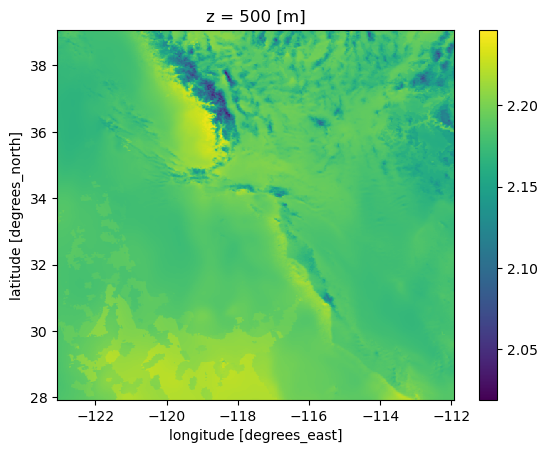

In [28]:
# We can plot the results
# We add the wet and hydrostatic delays to get the total delays
(ds['wet'] + ds['hydro']).interp(z=500).plot()

## Projecting to a new coordinate system

RAiDER can project the delay results to a specified coordinate system with specified grid spacing. This is particularly useful for cube outputs. 

Notice that RAiDER will re-use the pre-existing weather model data

In [30]:
# This example projects the delays into a CA state projection (EPSG 3310) with 1-km spacing. 
!raider.py example_yamls/raider_example_LA_bbox-newproject.yaml 

Invalid extension GTiff for cube. Defaulting to .nc
Output cube spacing: 0.02 degrees
Output SNWE: [-1115140.3919601939, 145728.2043301938, -304336.7959885741, 800630.4896004864]
Starting to run the weather model calculation
Requested date,time: 20200103, 00:00
Beginning weather model pre-processing
Extent of the weather model is (xmin, ymin, xmax, ymax):-130.71, 22.76, -109.20, 46.79
Extent of the input is (xmin, ymin, xmax, ymax): -123.06, 27.94, -111.94, 39.06
CRITICAL: There are missing delay values. Check your inputs.

Successfully wrote delay cube to: ./HRRR_tropo_20200103T000000_ztd.nc



In [31]:
# Let's look at the results
# Notice that the x- and y- values have changed
ds = xr.load_dataset('HRRR_tropo_20200103T000000_ztd.nc')
ds

<xarray.Dataset>
Dimensions:  (z: 5, y: 632, x: 554)
Coordinates:
  * x        (x) float64 -3.043e+05 -3.023e+05 ... 7.997e+05 8.017e+05
  * y        (y) float64 1.457e+05 1.437e+05 1.417e+05 ... -1.114e+06 -1.116e+06
  * z        (z) float64 0.0 50.0 100.0 500.0 1e+03
Data variables:
    wet      (z, y, x) float64 0.06148 0.06087 0.06214 ... 0.04157 0.04152
    hydro    (z, y, x) float64 2.276 2.276 2.275 2.275 ... 2.004 2.004 2.004
    crs      int64 -2147483647
Attributes:
    Conventions:           CF-1.7
    title:                 RAiDER geo cube
    source:                HRRR_2020_01_03_T00_00_00_27N_40N_124W_111W.nc
    history:               2024-01-09 02:51:02.470993 RAiDER
    description:           RAiDER geo cube - zenith
    reference_time:        20200103T00:00:00
    model_name:            HRRR
    model_times_used:      20200103T00:00:00
    interpolation_method:  center_time

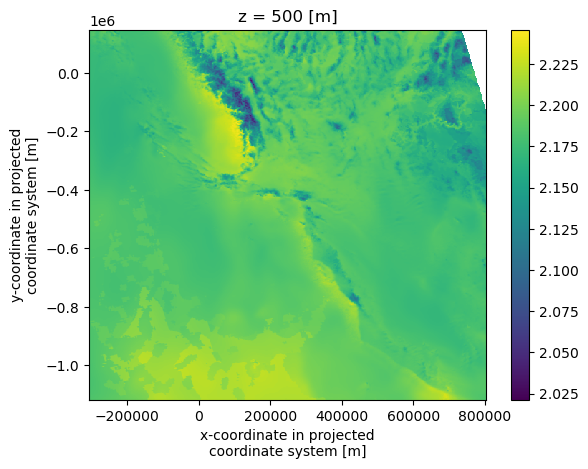

In [32]:
# We can plot the results
# We add the wet and hydrostatic delays to get the total delays
(ds['wet'] + ds['hydro']).interp(z=500).plot()

### Compute Zenith delays using a GNSS station list
<a id='station_list_example'></a>

When using a GNSS station list, the program by default will create a bounding box around the list of points. 
For demonstration purposes, we will use an example list of stations from
the L.A. area so that we don't have to download another weather model file. 

The station file **must be comma-delimited, and must contain at the minimum column names "Lat" and "Lon."** By default, RAiDER will download a DEM to get the height information for the list of stations; if the heights are specified in a column named "Hgt_m" RAiDER will use those and this will save some processing time. 

In [33]:
!head data/sample_gnss_list.csv

ID,Lat,Lon,Hgt_m
5PTS,36.429178603000004,-120.264976914,56.5231551
7OAK,37.59498606,-114.75908955700001,1713.2781037999996
7ODM,34.116406899999994,-117.093191981,762.0717087
ACSB,33.274264933000005,-117.444891086,-12.2960356
ACSX,33.274265297,-117.44489206899999,-12.291230300000002
AERO,32.80746746,-117.12437979399999,92.6906227
AGMT,34.594281855,-116.429377366,1337.8227700999996
AIAH,33.849159884,-117.86247482200001,38.2203257
AISD,33.023891888,-117.085783284,141.587007


In [34]:
!raider.py example_yamls/raider_example_LA_GNSS.yaml

Output cube spacing: 0.02 degrees
Output SNWE: [28.98, 39.06, -123.0, -112.96]
Starting to run the weather model calculation
Requested date,time: 20200103, 00:00
Beginning weather model pre-processing
Number of weather model nodes: 22178244
Shape of weather model: (814, 478, 57)
Bounds of the weather model: -1410306.15/1028693.85/-2634520.14/-1203520.14 (SNWE)
Weather model: HRRR
Mean value of the wet refractivity: 20.572176
Mean value of the hydrostatic refractivity: 176.371674

======Weather Model class object=====
Weather model time: 2020-01-03 00:00:00
Latitude resolution: 0.02702702702702703
Longitude resolution: 0.02702702702702703
Native projection: PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",ELLIPSOID["unknown",6371229,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],CONVERSION["unknown",METHOD["Lambert Conic Conformal (2SP)",ID["EPSG",9802]],PARAMETER["Latitude of false origin",38.5,ANGLEUNIT["d

We can compare the files in weather_files to see what has been added: 

In [35]:
!ls -lt weather_files/

total 5416440
-rw-r--r--  1 carissamaurer  staff  804677724 Jan  8 18:54 HRRR_2020_01_03_T00_00_00_28N_40N_124W_112W.nc
-rw-r--r--  1 carissamaurer  staff  804677724 Jan  8 18:01 HRRR_2020_01_03_T00_00_00_27N_40N_124W_111W.nc
-rw-r--r--  1 carissamaurer  staff  804677724 Jan  8 17:48 HRRR_2020_01_03_T00_00_00_24N_46N_124W_112W.nc
-rw-r--r--  1 carissamaurer  staff  317570039 Jan  8 17:47 HRRR_2020_01_03_T00_00_00.nc
drwxr-xr-x  4 carissamaurer  staff        128 Jan  8 17:46 hrrr
-rw-r--r--  1 carissamaurer  staff     460380 Jan  2 17:38 HRRR_2018_11_13_T00_00_00_36N_38N_77W_75W.nc
-rw-r--r--  1 carissamaurer  staff     231991 Jan  2 17:38 HRRR_2018_11_13_T00_00_00.nc
-rw-r--r--  1 carissamaurer  staff    6153412 Jan  2 17:35 HRRR-AK_2018_11_01_T00_00_00_60N_62N_152W_148W.nc
-rw-r--r--  1 carissamaurer  staff    2463516 Jan  2 17:35 HRRR-AK_2018_11_01_T00_00_00.nc
drwxr-xr-x  3 carissamaurer  staff         96 Jan  2 17:34 hrrrak
-rw-r--r--  1 carissamaurer  staff     460380 Jan  2 17:33

We also have a new .csv file in the base directory, which has been copied from the original station list file and to which has been added some new variables.

In [36]:
!ls *.csv

GMAO_Delay_20200103T000000_ztd.csv HRRR_Delay_20200103T000000_ztd.csv


In [38]:
!head HRRR_Delay_20200103T000000_ztd.csv

ID,Lat,Lon,Hgt_m,wetDelay,hydroDelay,totalDelay
5PTS,36.429178603,-120.264976914,56.5231551,0.06769893240384994,2.2583462057195853,2.326045138123435
7OAK,37.59498606,-114.759089557,1713.2781037999996,0.0,0.0,0.0
7ODM,34.116406899999994,-117.093191981,762.0717087,0.06026437565854157,2.0645868512894885,2.12485122694803
ACSB,33.274264933000005,-117.444891086,-12.2960356,0.0,0.0,0.0
ACSX,33.274265297,-117.444892069,-12.291230300000002,0.0,0.0,0.0
AERO,32.80746746,-117.124379794,92.6906227,0.08066702834681952,2.237471193881926,2.3181382222287454
AGMT,34.594281855,-116.429377366,1337.8227700999996,0.0,0.0,0.0
AIAH,33.849159884,-117.862474822,38.2203257,0.0881366207163865,2.252754969591584,2.3408915903079706
AISD,33.023891888,-117.085783284,141.587007,0.08598969461370641,2.2246400319820143,2.3106297265957205


You can see that the new .csv file contains the original station data, but with the addition of the wet, hydrostatic, and total delays, all in meters. 

### Visualizing Zenith delays for a list of GNSS stations
<a id='station_list_visualization'></a>

Once we have the delays in the .csv file, we can use Pandas to view and manipulate the data

In [42]:
delays = pd.read_csv('HRRR_Delay_20200103T000000_ztd.csv')

In [43]:
delays.head()

,ID,Lat,Lon,Hgt_m,wetDelay,hydroDelay,totalDelay
0,5PTS,36.429179,-120.264977,56.523155,0.067699,2.258346,2.326045
1,7OAK,37.594986,-114.759090,1713.278104,0.000000,0.000000,0.000000
2,7ODM,34.116407,-117.093192,762.071709,0.060264,2.064587,2.124851
3,ACSB,33.274265,-117.444891,-12.296036,0.000000,0.000000,0.000000
4,ACSX,33.274265,-117.444892,-12.291230,0.000000,0.000000,0.000000


In our case, the existing weather model did not cover the entire area, so some of the delays are zeros. We can filter these out: 

In [44]:
print(len(delays))
delays = delays[delays['totalDelay']!=0]
print(len(delays))

1353
816


We expect that total delays will be correlated with elevation, so we can create a plot to test: 

<Axes: xlabel='Height (m)', ylabel='Total Delay (m)'>

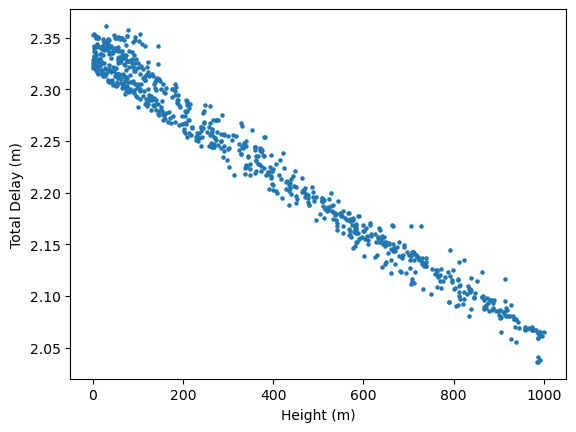

In [45]:
delays.plot.scatter(x='Hgt_m',y='totalDelay', marker='.', xlabel = 'Height (m)', ylabel='Total Delay (m)')

We can also plot the delays in space. 

<Axes: xlabel='Lon', ylabel='Lat'>

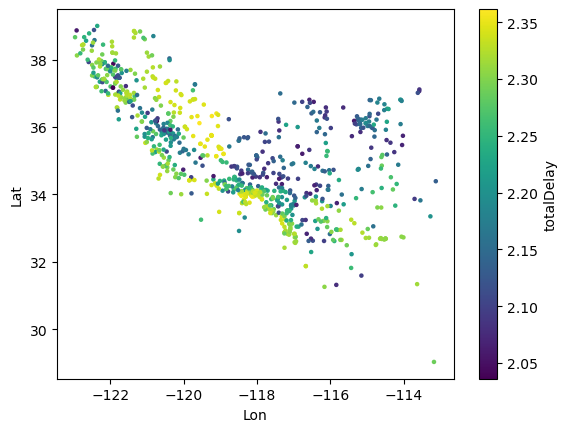

In [46]:
delays.plot.scatter(x='Lon',y='Lat', marker='.', c='totalDelay')